In [81]:
import sys
!{sys.executable} -m pip install PyAthena

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [82]:
from pyathena import connect
import math
import pandas as pd
import matplotlib.pyplot as plt

In [83]:
conn = connect(s3_staging_dir='s3://aws-simplified-results-antek',
               region_name='us-east-1')

In [84]:
METRICS_COLS = ','.join(['time', 'workflowId', 'jobId', 'name', 'parameter', 'valueStr', 'valueFloat', 'valueInt', 'valueDict'])
SYS_INFO_COLS = ','.join(['cpu', 'mem', 'jobId'])
JOB_DESCRIPTION_COLS = ','.join(['workflowName', 'size', 'version', 'hyperflowId', 'jobId', 'env', 'nodeName', 'executable', 'args', 'inputs', 'outputs', 'name', 'command'])

In [155]:
def query_athena_metrics(table):
    metrics_df = pd.read_sql('SELECT {} FROM hyperflow_logs.{};'.format(METRICS_COLS, table), conn)
    return metrics_df[metrics_df['time'].notnull()]

def query_athena_sysinfo(table):
    metrics_df = pd.read_sql('SELECT {} FROM hyperflow_logs.{};'.format(SYS_INFO_COLS, table), conn)
    return metrics_df[metrics_df['cpu'].notnull()]

def merge_value_num(df):
    df['valueNum'] = [val[0] if math.isnan(val[1]) else val[1] for val in zip(df['valueFloat'], df['valueInt'])]

In [191]:
def get_resource_mean(metrics_df, resource):
    return metrics_df[(metrics_df['parameter']==resource) & (~metrics_df['valueNum'].isna()) & (metrics_df['valueNum'] > 0)].groupby('name')['valueNum'].mean()

def compare_resource_mean(metrics_df1, metrics_df2, resource):
    ctime3 = get_resource_mean(metrics_df1, resource).to_frame()
    ctime32 = get_resource_mean(metrics_df2, resource).to_frame()
    merged = pd.concat([ctime3, ctime32], keys=['3','32'], axis=1)
    #merged.plot(kind='bar')
    return merged

def print_sys_info(sys_info, component='cpu'):
    if component == 'cpu':
        cpu_string = sys_info.iloc[0]['cpu']
        print(cpu_string[cpu_string.find('cores'):cpu_string.find('socket')])
        #print('cpu speed:',sys_info.iloc[0]['cpu']['speed'])
        #print('cpu cores:',sys_info.iloc[0]['cpu']['cores'])
        #print('cpu physicalcores:',sys_info.iloc[0]['cpu']['physicalCores'])
        #print('cpu processors:',sys_info.iloc[0]['cpu']['processors'])

In [187]:
# aws/t3.large/montage2__0_01__1_0_0__2020_06_01_18_14_25
# aws/t3.2xlarge/montage2__0.01__1.0.0__2020_06_20_19_36_56
metrics_df_large3 = query_athena_metrics('montage2__0_01__1_0_0__2020_06_01_18_14_25') # aws/t3.large/montage2__0_01__1_0_0__2020_06_01_18_14_25
merge_value_num(metrics_df_large3)
metrics_df_large32 = query_athena_metrics('montage2__0_01__1_0_0__2020_06_20_19_36_56') # aws/t3.large/montage2__0_01__1_0_0__2020_06_01_18_14_25
merge_value_num(metrics_df_large32)

In [197]:
sysinfo_df_large3 = query_athena_sysinfo('montage2__0_01__1_0_0__2020_06_01_18_14_25') # aws/t3.large/montage2__0_01__1_0_0__2020_06_01_18_14_25
sysinfo_df_large32 = query_athena_sysinfo('montage2__0_01__1_0_0__2020_06_20_19_36_56') # aws/t3.large/montage2__0_01__1_0_0__2020_06_01_18_14_25
print('CPU info 3: ', end = '')
print_sys_info(sysinfo_df_large3)
print('CPU info 3.2: ', end = '')
print_sys_info(sysinfo_df_large32)

CPU info 3: cores=2, physicalcores=2, processors=1, 
CPU info 3.2: cores=8, physicalcores=8, processors=1, 


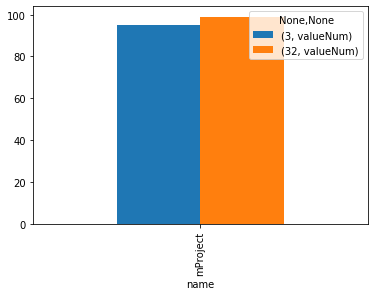

In [198]:
comparison = compare_resource_mean(metrics_df_large3, metrics_df_large32, 'cpu')
comparison.plot(kind='bar')

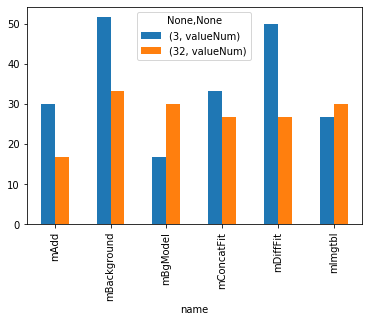

In [210]:
comparison = compare_resource_mean(metrics_df_large3, metrics_df_large32, 'ctime')
type(comparison)
comparison[:6].plot(kind='bar')

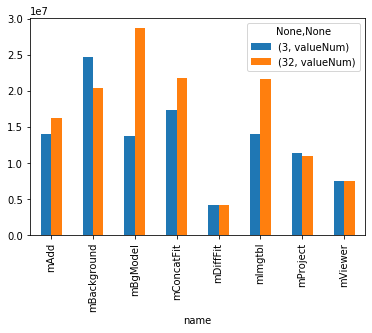

In [211]:
comparison = compare_resource_mean(metrics_df_large3, metrics_df_large32, 'memory')
comparison.plot(kind='bar')